In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import geopandas as gpd
from haversine import haversine
import matplotlib.pyplot as plt
import seaborn as sns

Q2_2

In [2]:
hs2_data = pd.read_csv('hs2_export_share_scaled.csv')
cluster_result = pd.read_csv('country_hs2_cluster_result.csv')


data = pd.merge(hs2_data, cluster_result[['country_name_full','i', 'year', 'cluster']], on=['i', 'year'], how='left')

hs2_columns = [col for col in hs2_data.columns if col.isdigit() and len(col) == 2]
X = data[hs2_columns].fillna(0)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [3]:
n_clusters = 5

kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
data['kmeans_cluster'] = kmeans.fit_predict(X_scaled)

cluster_compare = data[['i', 'year', 'cluster', 'kmeans_cluster']].drop_duplicates()
print("聚类结果匹配率：", (cluster_compare['cluster'] == cluster_compare['kmeans_cluster']).mean())

data[['i', 'year', 'country_name_full', 'cluster', 'kmeans_cluster']].to_csv('kmeans_cluster_result.csv', index=False)

聚类结果匹配率： 1.0


/var/folders/3x/10fl_rfn5dsgcjdkxgldfb8w0000gn/T/ipykernel_96770/1871530699.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


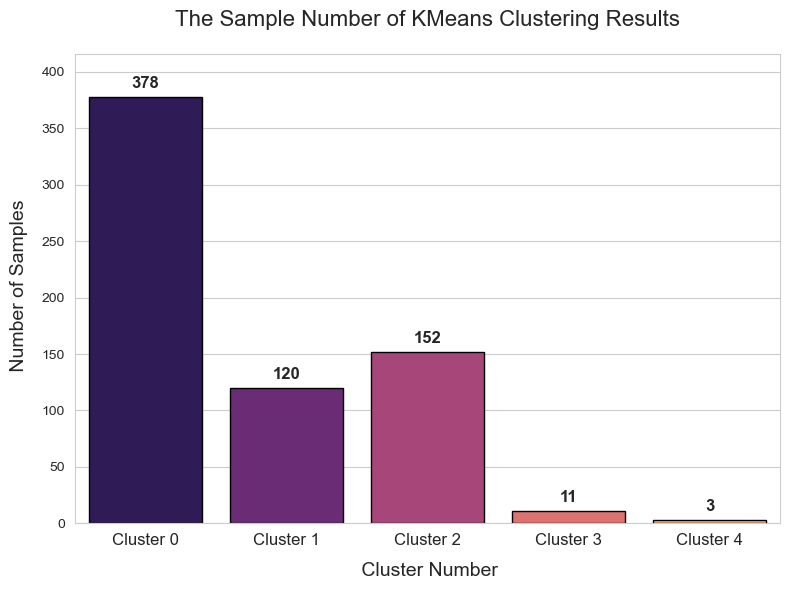

In [4]:
kmeans_counts = data['kmeans_cluster'].value_counts().sort_index()

plt.figure(figsize=(8, 6))
sns.set_style("whitegrid")

ax = sns.barplot(
    x=kmeans_counts.index, 
    y=kmeans_counts.values, 
    palette='magma',  
    edgecolor='black'  
)

plt.title('The Sample Number of KMeans Clustering Results', fontsize=16, pad=20)
plt.xlabel(' Cluster Number', fontsize=14, labelpad=10)
plt.ylabel(' Number of Samples', fontsize=14, labelpad=10)

plt.xticks(
    range(n_clusters), 
    [f'Cluster {i}' for i in range(n_clusters)],
    fontsize=12
)

for i, v in enumerate(kmeans_counts.values):
    ax.text(
        i, v + max(kmeans_counts.values)*0.02,
        f'{v}',
        ha='center',
        fontsize=12, 
        fontweight='bold'
    )

plt.ylim(0, max(kmeans_counts.values) * 1.1)

plt.tight_layout()
plt.show()

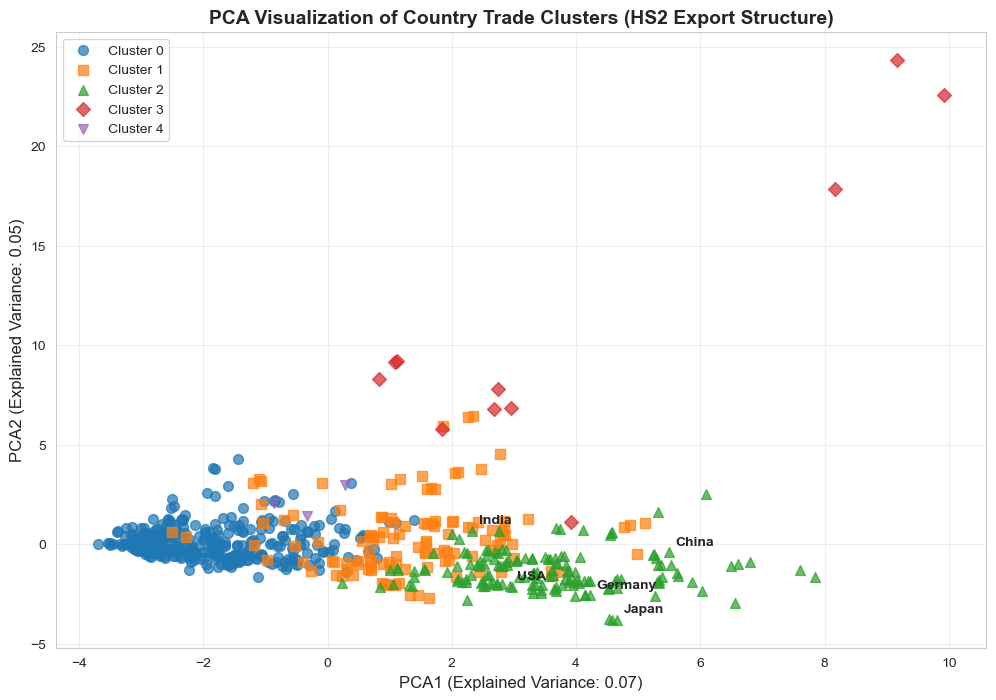

PCA解释方差比例： [0.07485746 0.0458837 ]
累计解释方差比例： 0.12074116744787769


In [5]:
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

data['pca1'] = X_pca[:, 0]
data['pca2'] = X_pca[:, 1]

plt.rcParams['font.sans-serif'] = ['Arial']
plt.figure(figsize=(12, 8))

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
markers = ['o', 's', '^', 'D', 'v']

for cluster in range(n_clusters):
    cluster_data = data[data['cluster'] == cluster]
    plt.scatter(
        cluster_data['pca1'], cluster_data['pca2'],
        c=colors[cluster], marker=markers[cluster], s=50, alpha=0.7,
        label=f'Cluster {cluster}'
    )

key_countries = {156: 'China', 842: 'USA', 392: 'Japan', 276: 'Germany', 699: 'India'}
for country_code, country_name in key_countries.items():
    country_data = data[data['i'] == country_code].iloc[0]
    plt.annotate(
        country_name,
        xy=(country_data['pca1'], country_data['pca2']),
        xytext=(5, 5), textcoords='offset points',
        fontsize=10, fontweight='bold'
    )

plt.title('PCA Visualization of Country Trade Clusters (HS2 Export Structure)', fontsize=14, fontweight='bold')
plt.xlabel(f'PCA1 (Explained Variance: {pca.explained_variance_ratio_[0]:.2f})', fontsize=12)
plt.ylabel(f'PCA2 (Explained Variance: {pca.explained_variance_ratio_[1]:.2f})', fontsize=12)
plt.legend(fontsize=10)
plt.grid(alpha=0.3)
plt.savefig('pca_cluster_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

print("PCA解释方差比例：", pca.explained_variance_ratio_)
print("累计解释方差比例：", sum(pca.explained_variance_ratio_))

筛选前HS2特征数：96
筛选后HS2特征数：74
筛选后PCA解释方差比例：[0.08559323 0.057549  ]
筛选后累计解释方差比例：0.143


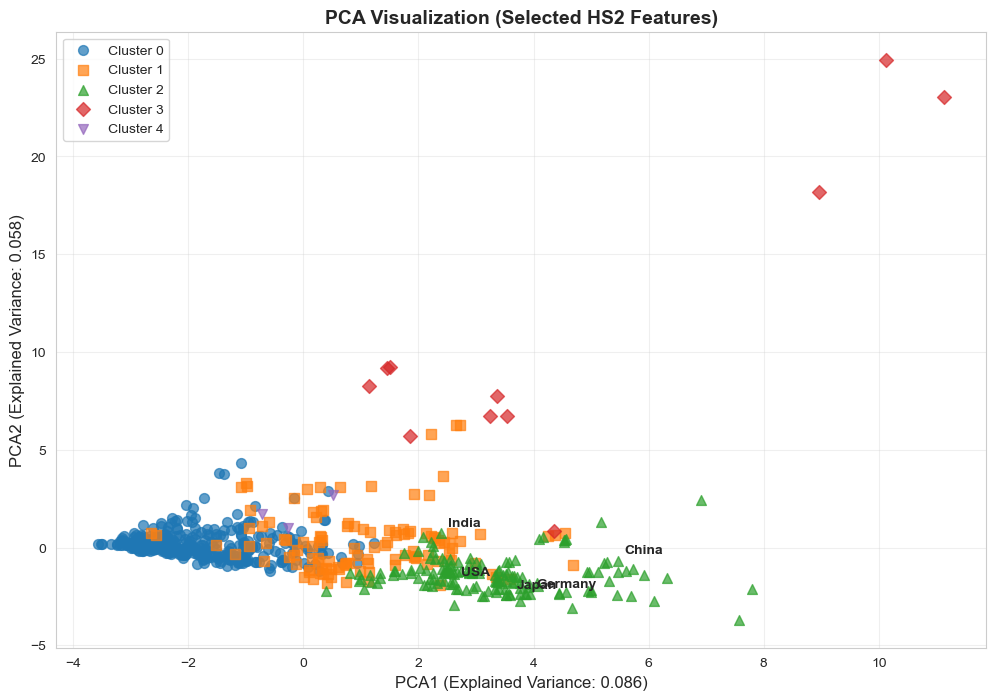

In [6]:
hs2_var = X.var(axis=0)

var_threshold = hs2_var.quantile(0.2) 
selected_hs2 = hs2_var[hs2_var > var_threshold].index.tolist()
print(f"筛选前HS2特征数：{len(hs2_columns)}")
print(f"筛选后HS2特征数：{len(selected_hs2)}")

X_selected = X[selected_hs2].fillna(0)
X_selected_scaled = StandardScaler().fit_transform(X_selected)

pca_selected = PCA(n_components=2, random_state=42)
X_pca_selected = pca_selected.fit_transform(X_selected_scaled)

print(f"筛选后PCA解释方差比例：{pca_selected.explained_variance_ratio_}")
print(f"筛选后累计解释方差比例：{sum(pca_selected.explained_variance_ratio_):.3f}")

data['pca1_selected'] = X_pca_selected[:, 0]
data['pca2_selected'] = X_pca_selected[:, 1]

plt.figure(figsize=(12, 8))
for cluster in range(5):
    cluster_data = data[data['cluster'] == cluster]
    plt.scatter(
        cluster_data['pca1_selected'], cluster_data['pca2_selected'],
        c=colors[cluster], marker=markers[cluster], s=50, alpha=0.7,
        label=f'Cluster {cluster}'
    )
for country_code, country_name in key_countries.items():
    country_data = data[data['i'] == country_code].iloc[0]
    plt.annotate(
        country_name,
        xy=(country_data['pca1_selected'], country_data['pca2_selected']),
        xytext=(5, 5), textcoords='offset points',
        fontsize=10, fontweight='bold'
    )
plt.title('PCA Visualization (Selected HS2 Features)', fontsize=14, fontweight='bold')
plt.xlabel(f'PCA1 (Explained Variance: {pca_selected.explained_variance_ratio_[0]:.3f})', fontsize=12)
plt.ylabel(f'PCA2 (Explained Variance: {pca_selected.explained_variance_ratio_[1]:.3f})', fontsize=12)
plt.legend(fontsize=10)
plt.grid(alpha=0.3)
plt.savefig('pca_cluster_selected.png', dpi=300, bbox_inches='tight')
plt.show()

In [7]:

pca_loadings = pd.DataFrame(
    pca.components_.T, 
    columns=['PCA1', 'PCA2'],
    index=hs2_columns
)

pca1_top5_pos = pca_loadings['PCA1'].nlargest(5)
pca1_top5_neg = pca_loadings['PCA1'].nsmallest(5)
pca2_top5_pos = pca_loadings['PCA2'].nlargest(5)
pca2_top5_neg = pca_loadings['PCA2'].nsmallest(5)

print("与PCA1正相关最高的5个HS2产品：")
print(pca1_top5_pos)
print("\n与PCA1负相关最高的5个HS2产品：")
print(pca1_top5_neg)
print("\n与PCA2正相关最高的5个HS2产品：")
print(pca2_top5_pos)
print("\n与PCA2负相关最高的5个HS2产品：")
print(pca2_top5_neg)

与PCA1正相关最高的5个HS2产品：
39    0.246227
96    0.241189
84    0.225676
59    0.217478
94    0.211225
Name: PCA1, dtype: float64

与PCA1负相关最高的5个HS2产品：
27   -0.134416
71   -0.112096
26   -0.101335
03   -0.089426
89   -0.068554
Name: PCA1, dtype: float64

与PCA2正相关最高的5个HS2产品：
53    0.367124
57    0.331377
55    0.328799
14    0.321845
65    0.310372
Name: PCA2, dtype: float64

与PCA2负相关最高的5个HS2产品：
84   -0.168536
87   -0.138689
85   -0.115069
90   -0.114027
37   -0.109386
Name: PCA2, dtype: float64


In [8]:
cluster_hs2_mean = data.groupby('cluster')[hs2_columns].mean()

top3_hs2 = {}
for cluster in range(n_clusters):
    top3 = cluster_hs2_mean.loc[cluster].nlargest(3)
    top3_hs2[cluster] = [(hs2, f'{val:.3f}') for hs2, val in top3.items()]

print("各聚类Top3 HS2产品（标准化份额）：")
for cluster, products in top3_hs2.items():
    print(f"Cluster {cluster}: {products}")

各聚类Top3 HS2产品（标准化份额）：
Cluster 0: [('27', '0.304'), ('71', '0.234'), ('26', '0.222')]
Cluster 1: [('42', '0.811'), ('96', '0.715'), ('61', '0.686')]
Cluster 2: [('84', '1.195'), ('59', '1.083'), ('39', '1.029')]
Cluster 3: [('53', '6.420'), ('14', '5.347'), ('65', '4.830')]
Cluster 4: [('07', '12.648'), ('05', '11.814'), ('46', '5.132')]


/var/folders/3x/10fl_rfn5dsgcjdkxgldfb8w0000gn/T/ipykernel_96770/33770645.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


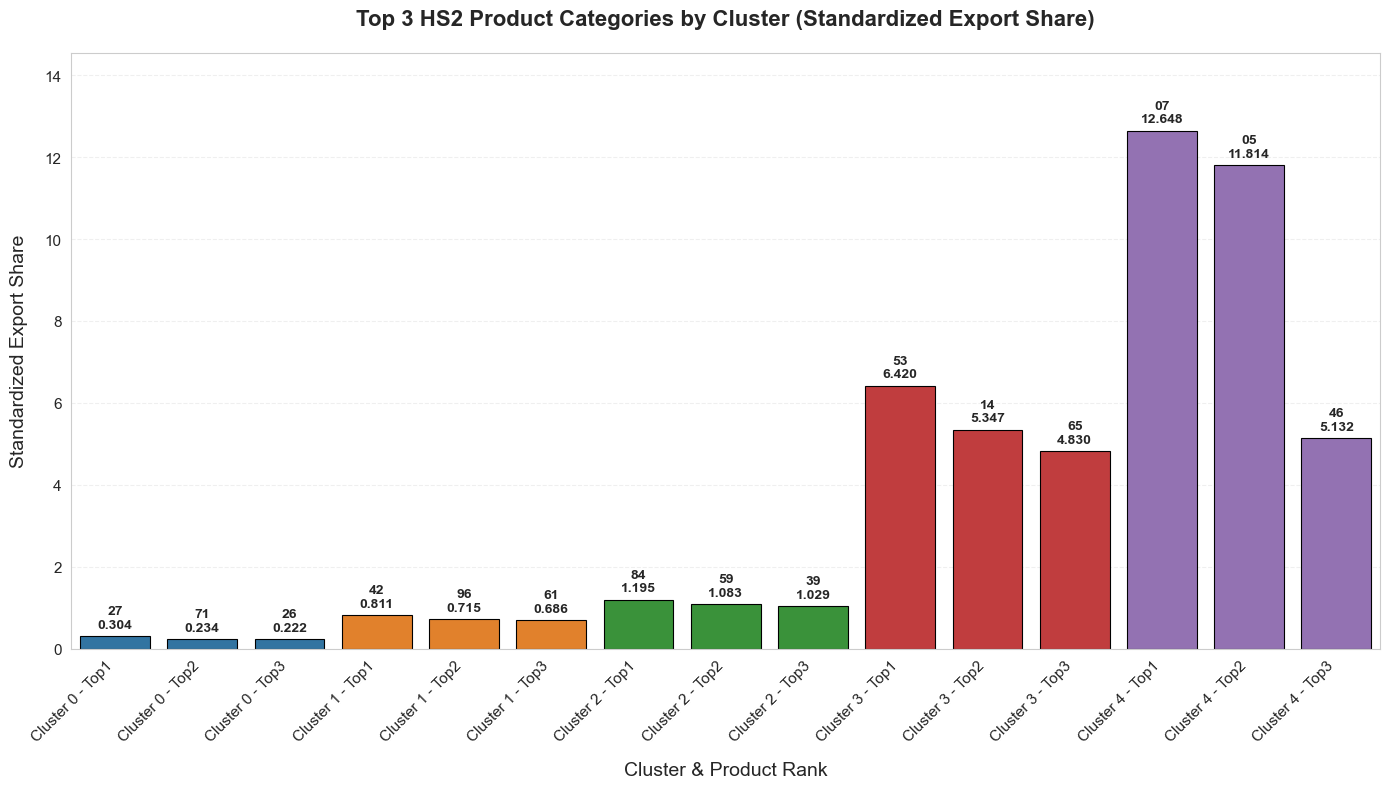


各聚类Top3 HS2产品可视化数据汇总：
      Cluster Top_Rank HS2_Code  Standardized_Share
0   Cluster 0     Top1       27               0.304
1   Cluster 0     Top2       71               0.234
2   Cluster 0     Top3       26               0.222
3   Cluster 1     Top1       42               0.811
4   Cluster 1     Top2       96               0.715
5   Cluster 1     Top3       61               0.686
6   Cluster 2     Top1       84               1.195
7   Cluster 2     Top2       59               1.083
8   Cluster 2     Top3       39               1.029
9   Cluster 3     Top1       53               6.420
10  Cluster 3     Top2       14               5.347
11  Cluster 3     Top3       65               4.830
12  Cluster 4     Top1       07              12.648
13  Cluster 4     Top2       05              11.814
14  Cluster 4     Top3       46               5.132


In [ ]:
cluster_product_data = []
for cluster_id, products in top3_hs2.items():
    for idx, (hs2_code, share) in enumerate(products, 1):  
        cluster_product_data.append({
            'Cluster': f'Cluster {cluster_id}',  
            'Top_Rank': f'Top{idx}',            
            'HS2_Code': hs2_code,             
            'Standardized_Share': float(share)  
        })
product_df = pd.DataFrame(cluster_product_data)


plt.figure(figsize=(14, 8))
sns.set_style("whitegrid")
palette = sns.color_palette("tab10", n_colors=n_clusters) 


product_df['Cluster_Top'] = product_df['Cluster'] + ' - ' + product_df['Top_Rank']
ax = sns.barplot(
    x='Cluster_Top', 
    y='Standardized_Share', 
    data=product_df,
    palette=[color for color in palette for _ in range(3)],  
    edgecolor='black',  
    linewidth=0.8
)

plt.title('Top 3 HS2 Product Categories by Cluster (Standardized Export Share)', 
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Cluster & Product Rank', fontsize=14, labelpad=12)
plt.ylabel('Standardized Export Share', fontsize=14, labelpad=12)
plt.xticks(rotation=45, ha='right', fontsize=11)
plt.yticks(fontsize=11)

for i, bar in enumerate(ax.patches):
    
    height = bar.get_height()
    current_data = product_df.iloc[i]
    label = f"{current_data['HS2_Code']}\n{current_data['Standardized_Share']:.3f}"
    ax.text(bar.get_x() + bar.get_width()/2, height + max(product_df['Standardized_Share'])*0.01,
            label, ha='center', va='bottom', fontsize=10, fontweight='bold')
plt.ylim(0, max(product_df['Standardized_Share']) * 1.15)

ax.yaxis.grid(True, alpha=0.3, linestyle='--')
ax.set_axisbelow(True)

plt.tight_layout()
plt.savefig('cluster_top3_hs2_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n各聚类Top3 HS2产品可视化数据汇总：")
print(product_df[['Cluster', 'Top_Rank', 'HS2_Code', 'Standardized_Share']].round(3))

In [10]:
data1 = pd.read_csv('kmeans_cluster_result.csv')
trade_data = pd.read_csv('cleaned_trade_data_2016_2018.csv')

data1['i'] = data1['i'].astype(str).str.zfill(3)
trade_data['i'] = trade_data['i'].astype(str).str.zfill(3)
trade_data['j'] = trade_data['j'].astype(str).str.zfill(3)

In [11]:
china_code = '156'
world = gpd.read_file('countries_shapefile/cn_primary_countries.shp')
world['iso_numeric'] = world['iso_n3'].astype(str).str.zfill(3)
world = world.to_crs(epsg=4326)
world['centroid'] = world['geometry'].centroid
world['lat'] = world['centroid'].y
world['lon'] = world['centroid'].x

china_info = world[world['iso_numeric'] == china_code].iloc[0]
china_lat, china_lon = china_info['lat'], china_info['lon']

country_dist_to_china = {}
for country_code in data1['i'].unique():
    country_info = world[world['iso_numeric'] == country_code]
    if len(country_info) == 0:
        country_dist_to_china[country_code] = 0 
        continue
    cntry_lat, cntry_lon = country_info['lat'].iloc[0], country_info['lon'].iloc[0]
    country_dist_to_china[country_code] = haversine((china_lat, china_lon), (cntry_lat, cntry_lon))

china_export = trade_data[trade_data['i'] == china_code].copy()


china_export_with_cluster = china_export.merge(
    data1[['i', 'cluster']].drop_duplicates(), 
    left_on='j',
    right_on='i', 
    how='left'
).rename(columns={'cluster': 'j_cluster'}) 

china_export_with_cluster['distance_to_china_km'] = china_export_with_cluster['j'].map(country_dist_to_china)

china_export_valid = china_export_with_cluster.dropna(subset=['j_cluster', 'distance_to_china_km', 'v'])
china_export_valid = china_export_valid[china_export_valid['v'] > 0] 

cluster_weighted_dist = china_export_valid.groupby('j_cluster').apply(
    lambda x: (x['distance_to_china_km'] * x['v']).sum() / x['v'].sum()
).reset_index(name='export_weighted_distance_km')


print("中国对各聚类国家的出口加权平均距离（公里）：")
print(cluster_weighted_dist.round(2))

/var/folders/3x/10fl_rfn5dsgcjdkxgldfb8w0000gn/T/ipykernel_96770/2442726069.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  world['centroid'] = world['geometry'].centroid


中国对各聚类国家的出口加权平均距离（公里）：
   j_cluster  export_weighted_distance_km
0          0                      8152.18
1          1                      1905.08
2          2                      3287.67
3          3                      3304.96
4          4                     10580.58


/var/folders/3x/10fl_rfn5dsgcjdkxgldfb8w0000gn/T/ipykernel_96770/2442726069.py:36: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  cluster_weighted_dist = china_export_valid.groupby('j_cluster').apply(


/var/folders/3x/10fl_rfn5dsgcjdkxgldfb8w0000gn/T/ipykernel_96770/3165632117.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax1 = sns.barplot(


(0.0, 11638.632960435376)

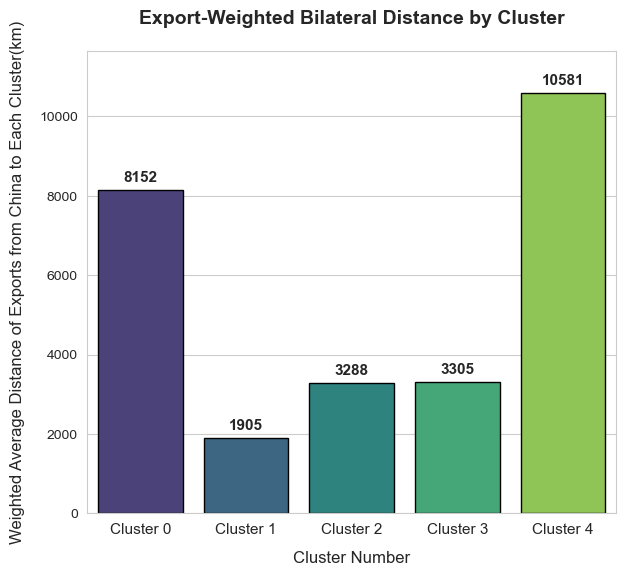

In [12]:
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
sns.set_style("whitegrid")
ax1 = sns.barplot(
    x='j_cluster', 
    y='export_weighted_distance_km', 
    data=cluster_weighted_dist,
    palette='viridis',
    edgecolor='black'
)
plt.title('Export-Weighted Bilateral Distance by Cluster', fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Cluster Number', fontsize=12, labelpad=10)
plt.ylabel('Weighted Average Distance of Exports from China to Each Cluster(km)', fontsize=12, labelpad=10)
plt.xticks(range(len(cluster_weighted_dist)), [f'Cluster {i}' for i in cluster_weighted_dist['j_cluster']], fontsize=11)

for i, v in enumerate(cluster_weighted_dist['export_weighted_distance_km']):
    ax1.text(i, v + max(cluster_weighted_dist['export_weighted_distance_km'])*0.02,
             f'{v:.0f}', ha='center', fontsize=11, fontweight='bold')
plt.ylim(0, max(cluster_weighted_dist['export_weighted_distance_km'])*1.1)


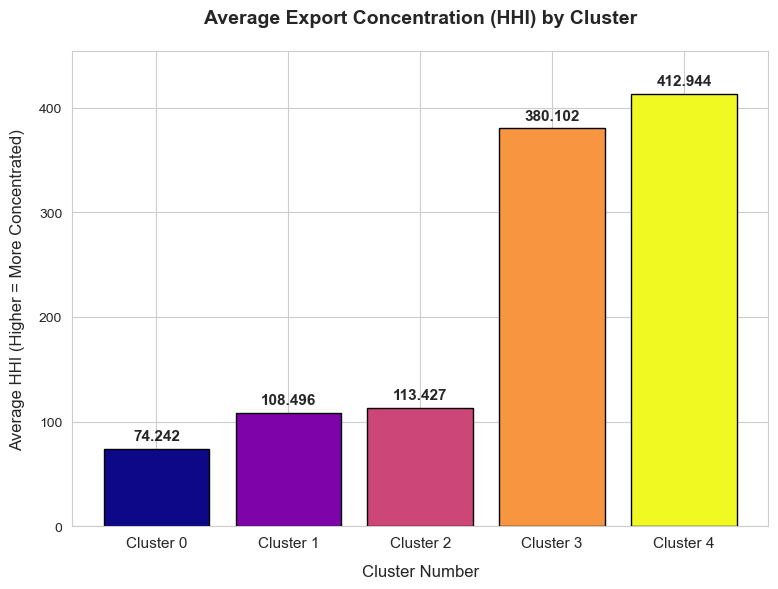


聚类特征汇总（距离 + 出口集中度）：
   j_cluster  export_weighted_distance_km  avg_hhi  hhi_std
0          0                     8152.176   74.242   78.307
1          1                     1905.076  108.496   71.628
2          2                     3287.669  113.427  170.898
3          3                     3304.965  380.102  295.996
4          4                    10580.575  412.944  144.186


In [13]:
# 1. 计算每个国家-年份的HHI（HS2出口份额平方和）
hs2_columns = [col for col in data.columns if col.isdigit() and len(col) == 2]
data_hhi = data.dropna(subset=['cluster'] + hs2_columns).copy()  # 过滤无效数据
data_hhi['hhi'] = data_hhi[hs2_columns].pow(2).sum(axis=1)  # HHI = 平方和

# 2. 按聚类分组，计算平均HHI（反映聚类内国家的出口集中度特征）
cluster_hhi = data_hhi.groupby('cluster')['hhi'].agg(['mean', 'std']).reset_index()
cluster_hhi.columns = ['cluster', 'avg_hhi', 'hhi_std']
cluster_hhi = cluster_hhi.sort_values('cluster')

# 3. HHI可视化（与加权距离并列展示）
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 2)
clusters = cluster_hhi['cluster']
avg_hhi = cluster_hhi['avg_hhi']
hhi_std = cluster_hhi['hhi_std']

bars = plt.bar(
    clusters, avg_hhi,
    color=plt.cm.plasma(np.linspace(0, 1, len(clusters))),
    edgecolor='black'
)

plt.title('Average Export Concentration (HHI) by Cluster', fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Cluster Number', fontsize=12, labelpad=10)
plt.ylabel('Average HHI (Higher = More Concentrated)', fontsize=12, labelpad=10)
plt.xticks(range(len(clusters)), [f'Cluster {i}' for i in clusters], fontsize=11)

# 标注具体数值
for i, v in enumerate(avg_hhi):
    plt.text(i, v + max(avg_hhi) * 0.02,
             f'{v:.3f}', ha='center', fontsize=11, fontweight='bold')

plt.ylim(0, max(avg_hhi) * 1.1)

plt.tight_layout()
plt.savefig('cluster_distance_hhi_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

# 输出最终聚类特征汇总表
cluster_summary = cluster_weighted_dist.merge(
    cluster_hhi[['cluster', 'avg_hhi', 'hhi_std']],
    left_on='j_cluster',
    right_on='cluster',
    how='left'
).drop(columns=['cluster']).round(3)
print("\n聚类特征汇总（距离 + 出口集中度）：")
print(cluster_summary)
cluster_summary.to_csv('cluster_characteristics_summary.csv', index=False)